# 1. Задаем функции для генерации одиночного пика и пары наложенных пиков

In [229]:
from numpy import exp

def gaus(t, s, mu, a):
    return a*exp(-((t-mu)**2)/(2*s**2))

def gpeak(mu, s, a, size, start, end):
    out = []
    dt = (end - start)/(size-1)
    for i in range(size):
        out.append(gaus(start + i*dt, s, mu, a))
    return out

def peak_pair(mu1, s1, a1, mu2, s2, a2, size, start, end):
    peak1 = gpeak(mu1, s1, a1, size, start, end)
    peak2 = gpeak(mu2, s2, a2, size, start, end)
    out = []
    for i in range(size):
        out.append(peak1[i] + peak2[i])
    return out

### Формула для вычисления площади пика по его параметрам

In [2]:
from numpy import sqrt, pi

def peak_area(s, a):
    return a*sqrt(2*pi)*s

### Проверяем работоспособность функций для пиков

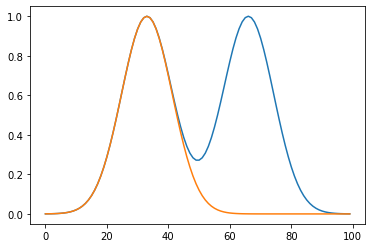

In [226]:
import matplotlib.pyplot as plt
plt.plot(peak_pair(4, 1, 1, 8, 1, 1, 100, 0, 12))
plt.plot(gpeak(4, 1, 1, 100, 0, 12))
#plt.plot(gpeak(8, 1, 1, 100, 0, 12))

# 2. Задаем функции для вычисления статистических моментов.
### Статистические моменты будут служить признаками, подаваемыми на вход нейросети

In [3]:
def moment(n, signal, start, end):
    size = len(signal)
    dt = (end-start)/(size-1)
    if n == 0: 
        return sum(signal)*dt
    elif n == 1:
        for_sum = []
        for i in range(size):
            for_sum.append(signal[i]*i*dt)
        m0 = moment(0, signal, start, end)
        return sum(for_sum)*dt/m0
    else:
        for_sum = []
        m1 = moment(1, signal, start, end)
        for i in range(size):
            for_sum.append(signal[i]*(i*dt-m1)**n)
        m0 = moment(0, signal, start, end)
        return sum(for_sum)*dt/m0

### Проверяем, сходятся ли нулевой момент и площадь пика по формуле, а также первый и второй момент с параметрами пика (m = 4, s = 1)

In [66]:
print(moment(0, gpeak(), 0, 12))
print(peak_area(1, 1))
print(moment(1, gpeak(), 0, 12))
print(sqrt(moment(2, gpeak(), 0, 12)))

2.5065675799688334
2.5066282746310002
4.000103840377672
0.9997888872989873


# 3. Задаем генератор датасета по N пар пиков с равномерно распределенными случайными значениями параметров

На вход НС подаются моменты, вычисленные по паре наложенных пиков, на выходе мы должны получить значения площади и положения вершины каждого из пиков в отдельности. Чтобы научить НС делать это, требуется тестовая выборка из большого числа сигналов, предположительно около 1000, для которых нужно вычислить 1) моменты, 2) положения вершин, 3) площади и сохранить все эти данные для дальнейшего обучения НС. Также, чтобы можно было визуализировать любую из пар пиков, для каждлой пары будем сохранять параметры каждого из пика. В итоге получается датафрейм из N строк, каждая строка содержит значения моментов, параметры пиков (включая положения их вершин) и площади пиков.

### Задаем функцию для генерации всех нужных значений (в виде массива) для одной смоделированной пары пиков с задаными параметрами.

Функция выдает массив (list) с элементами:<br> [mu1, s1, a1, area1, mu2, s2, a2, area2, m0, ..., mn],<br>
где mu, s, a - параметры моделируемого пика,<br>
area - вычисленная площадь каждого пика,<br>
mn - n-й момент сигнала с двумя наложенными пиками и т.п.

In [4]:
def peak_df_row(mu1, s1, a1, mu2, s2, a2, size, start, end, n):
    out = [mu1, s1, a1,
           peak_area(s1, a1),
           mu2, s2, a2,
           peak_area(s2, a2),
           size, start, end]
    for i in range(n):
        out.append(moment(i, peak_pair(mu1, s1, a1, mu2, s2, a2, size, start, end), start, end))
    return out

Проверяем на работоспособность

In [230]:
peak_df_row(4, 1, 1, 8, 1, 1, 100, 0, 12, 2)

[4,
 1,
 1,
 2.5066282746310002,
 8,
 1,
 1,
 2.5066282746310002,
 100,
 0,
 12,
 5.0131351599376694,
 6.000000000000001]

In [231]:
def rnd(min, max):
    from numpy.random import rand
    return min+(max-min)*rand()

In [234]:
from pandas import DataFrame

base_params_names = ['mu1','s1','a1','area1','mu2','s2','a2','area2','size','start','end']

mu_min = 3.2
mu_max = 4.8

space_btwn_peaks = 4

s_min = 0.6
s_max = 1.2

a_min = 0.1
a_max = 3.5

start = 0
end = 12
size = 100

def peaks_df(N, n):
    cols_names = base_params_names.copy()
    array = []
    for i in range(n):
        cols_names.append('m' + str(i))
    for i in range(N):
        mu1 = rnd(mu_min, mu_max)
        s1 = rnd(s_min, s_max)
        a1 = rnd(a_min, a_max)
        
        mu2 = rnd(mu_min, mu_max) + space_btwn_peaks
        s2 = rnd(s_min, s_max)
        a2 = rnd(a_min, a_max)
        
        array.append(peak_df_row(mu1, s1, a1, mu2, s2, a2, size, start, end, n))
    return DataFrame(data = array,
                     columns = cols_names)

In [235]:
num_moms = 5
df_used = peaks_df(10000, num_moms)
df_used

,mu1,s1,a1,area1,mu2,s2,a2,area2,size,start,end,m0,m1,m2,m3,m4
0,4.762945,0.627399,1.732083,2.723972,7.615734,1.012293,2.698025,6.846080,100,0,12,9.570013,6.803709,2.502117,-0.936953,13.330248
1,3.533511,0.864124,1.055076,2.285334,8.727301,1.002038,2.446360,6.144610,100,0,12,8.427226,7.317717,6.258525,-11.894940,87.058089
2,4.446404,0.691837,3.092288,5.362580,8.739398,0.936839,2.191064,5.145288,100,0,12,10.506868,6.547966,5.276856,1.683718,41.484989
3,3.660488,0.637849,2.650144,4.237184,8.531825,0.764769,1.500417,2.876288,100,0,12,7.113467,5.630178,6.194152,5.952876,55.926661
4,4.787402,1.048509,0.882624,2.319734,8.407522,0.923212,1.580471,3.657445,100,0,12,5.977037,7.002444,4.059833,-3.160433,33.187366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.729662,0.648701,3.222747,5.240354,8.713183,0.911487,2.532981,5.787251,100,0,12,11.026918,6.344627,6.827800,-0.007639,62.882129
9996,4.483027,1.047149,3.070708,8.060036,8.107797,0.688502,1.765406,3.046772,100,0,12,11.106751,5.477388,3.541138,2.932468,26.757784
9997,3.366471,0.750322,0.901771,1.696031,7.407058,1.137226,0.110852,0.315996,100,0,12,2.012016,4.001040,2.838834,7.160545,38.130929
9998,3.203810,1.015132,1.837696,4.676123,8.056020,0.894257,2.189376,4.907642,100,0,12,9.580725,5.690411,6.785456,-1.499020,69.228245


# Раздел с обучением НС
### пока представь, что его не существует

In [222]:
X = df_used.drop(base_params_names, axis = 1)
Y = df_used[['area1']]

In [223]:
from keras import models
from keras import layers
from keras.backend import clear_session
from tensorflow.keras.metrics import MeanAbsolutePercentageError

clear_session()
model = models.Sequential()

depth = 6
neurons = num_moms
model.add(layers.Dense(neurons, activation='relu', input_shape=(num_moms,)))
for i in range(depth):
    neurons = neurons*2
    model.add(layers.Dense(neurons, activation='relu', input_shape=(num_moms,)))
for i in range(depth):
    neurons = int(neurons/2)
    model.add(layers.Dense(neurons, activation='relu', input_shape=(num_moms,))) 
model.add(layers.Dense(1, activation='relu'))

model.compile(optimizer='adam', 
              loss='mse', #mse - mean square error, среднеквадратичная ошибка
              metrics=[MeanAbsolutePercentageError()])

In [224]:
model.fit(X, Y, epochs=100, batch_size = 80, verbose=1)
#model.evaluate(X, Y)

Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 15.2918 - mean_absolute_percentage_error: 112.1679
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 6.6197 - mean_absolute_percentage_error: 77.1864
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 3.8395 - mean_absolute_percentage_error: 52.4646
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 3.6596 - mean_absolute_percentage_error: 51.3886
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 3.4420 - mean_absolute_percentage_error: 49.4667
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 3.3592 - mean_absolute_percentage_error: 48.2904
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 3.3503 - mean_absolute_percentage_error: 48.3128
Epoch 8/100
125/125 [==============================] - 1s 5ms/step - loss: 3.2169 - mean_absolute_percentage_error: 47.3418
Epoch 

In [205]:
df_testy = peaks_df(3,num_moms)
Xtest = df_testy.drop(base_params_names, axis = 1)
Ytest = df_testy[['area1']]

In [206]:
model.predict(Xtest)

1/1 [==============================] - 0s 83ms/step


array([[5.378706 ],
       [5.2832437],
       [2.7263799]], dtype=float32)

In [207]:
Ytest

,area1
0,5.028011
1,5.600000
2,3.847796


In [106]:
df_testy.m0

0     6.164265
1    10.108731
2     8.608708
Name: m0, dtype: float64

примерно 32% погрешность

In [ ]:
model.add(layers.Dense(num_moms, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(64, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(128, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(256, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(128, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(64, activation='relu', input_shape=(num_moms,)))
model.add(layers.Dense(2, activation='relu'))